In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [115]:
df = pd.read_excel('Gestational Diabetic Dat Set.xlsx', index_col = 0)

In [116]:
df.head()

,Age,No of Pregnancy,Gestation in previous Pregnancy,BMI,HDL,Family History,unexplained prenetal loss,Large Child or Birth Default,PCOS,Sys BP,Dia BP,OGTT,Hemoglobin,Sedentary Lifestyle,Prediabetes,Class Label(GDM /Non GDM)
Case Number,,,,,,,,,,,,,,,,
1,22,2,1,NaN,55.0,0,0,0,0,102.0,69,NaN,12.0,0,0,0
2,26,2,1,NaN,53.0,0,0,0,0,101.0,63,NaN,12.4,0,0,0
3,29,1,0,NaN,50.0,0,0,0,0,118.0,79,NaN,14.3,0,0,0
4,28,2,1,NaN,51.0,0,0,0,0,99.0,70,NaN,15.0,0,0,0
5,21,2,1,NaN,52.0,0,0,0,0,116.0,65,NaN,15.0,0,0,0


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3525 entries, 1 to 3525
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              3525 non-null   int64  
 1   No of Pregnancy                  3525 non-null   int64  
 2   Gestation in previous Pregnancy  3525 non-null   int64  
 3   BMI                              2444 non-null   float64
 4   HDL                              2524 non-null   float64
 5   Family History                   3525 non-null   int64  
 6   unexplained prenetal loss        3525 non-null   int64  
 7   Large Child or Birth Default     3525 non-null   int64  
 8   PCOS                             3525 non-null   int64  
 9   Sys BP                           1820 non-null   float64
 10  Dia BP                           3525 non-null   int64  
 11  OGTT                             3012 non-null   float64
 12  Hemoglobin          

BMI, Sys BP, HDL, and OGTT have Nan.

In [118]:
df['Class Label(GDM /Non GDM)'].value_counts()

0    2153
1    1372
Name: Class Label(GDM /Non GDM), dtype: int64

Reasonably balanced.

Let's look at some of the things I'd expect to be good predictors. Start with quantitative. 

In [119]:
GDB = 'Class Label(GDM /Non GDM)'
def compare_quant(col):
    grid = sns.FacetGrid(df, row = GDB)
    grid.map(sns.histplot, col)

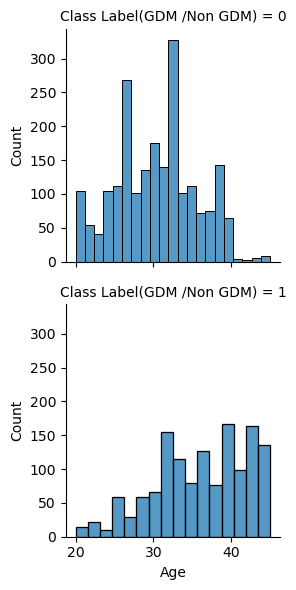

In [120]:
compare_quant('Age')

Skew right age distribution for GDB. 

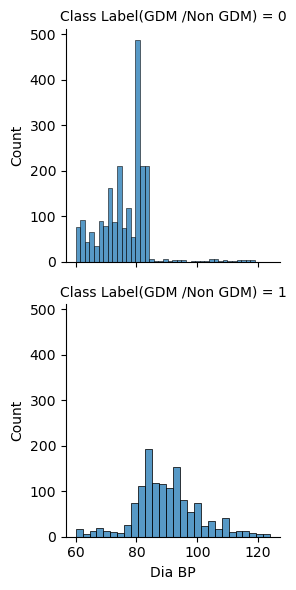

In [121]:
compare_quant('Dia BP')

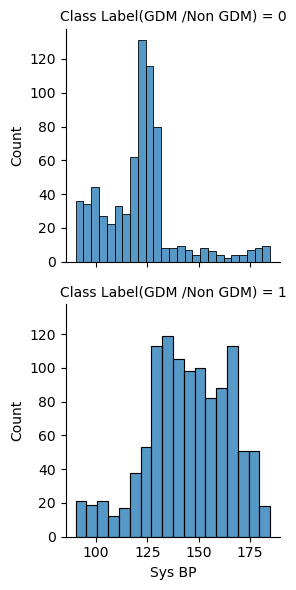

In [122]:
compare_quant('Sys BP')

Looks like we have something here too.

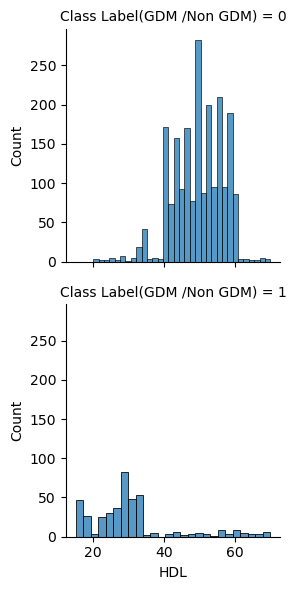

In [123]:
compare_quant('HDL')

Low HDL seems indicative.

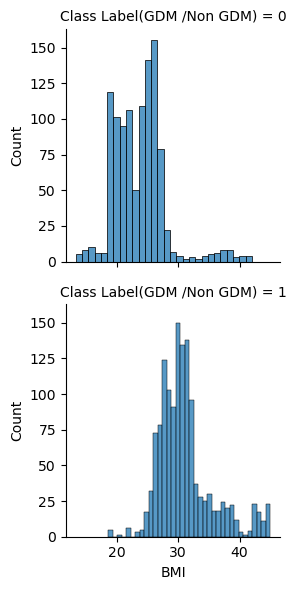

In [124]:
compare_quant('BMI')

BMI is also good.

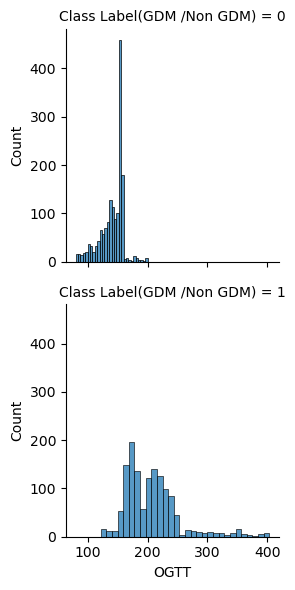

In [125]:
compare_quant('OGTT')

OGTT over 200 is 100 percent predictive; is this because it is the diagnostic criterion?

In [126]:
df[df['OGTT']>200][GDB].value_counts()

1    714
Name: Class Label(GDM /Non GDM), dtype: int64

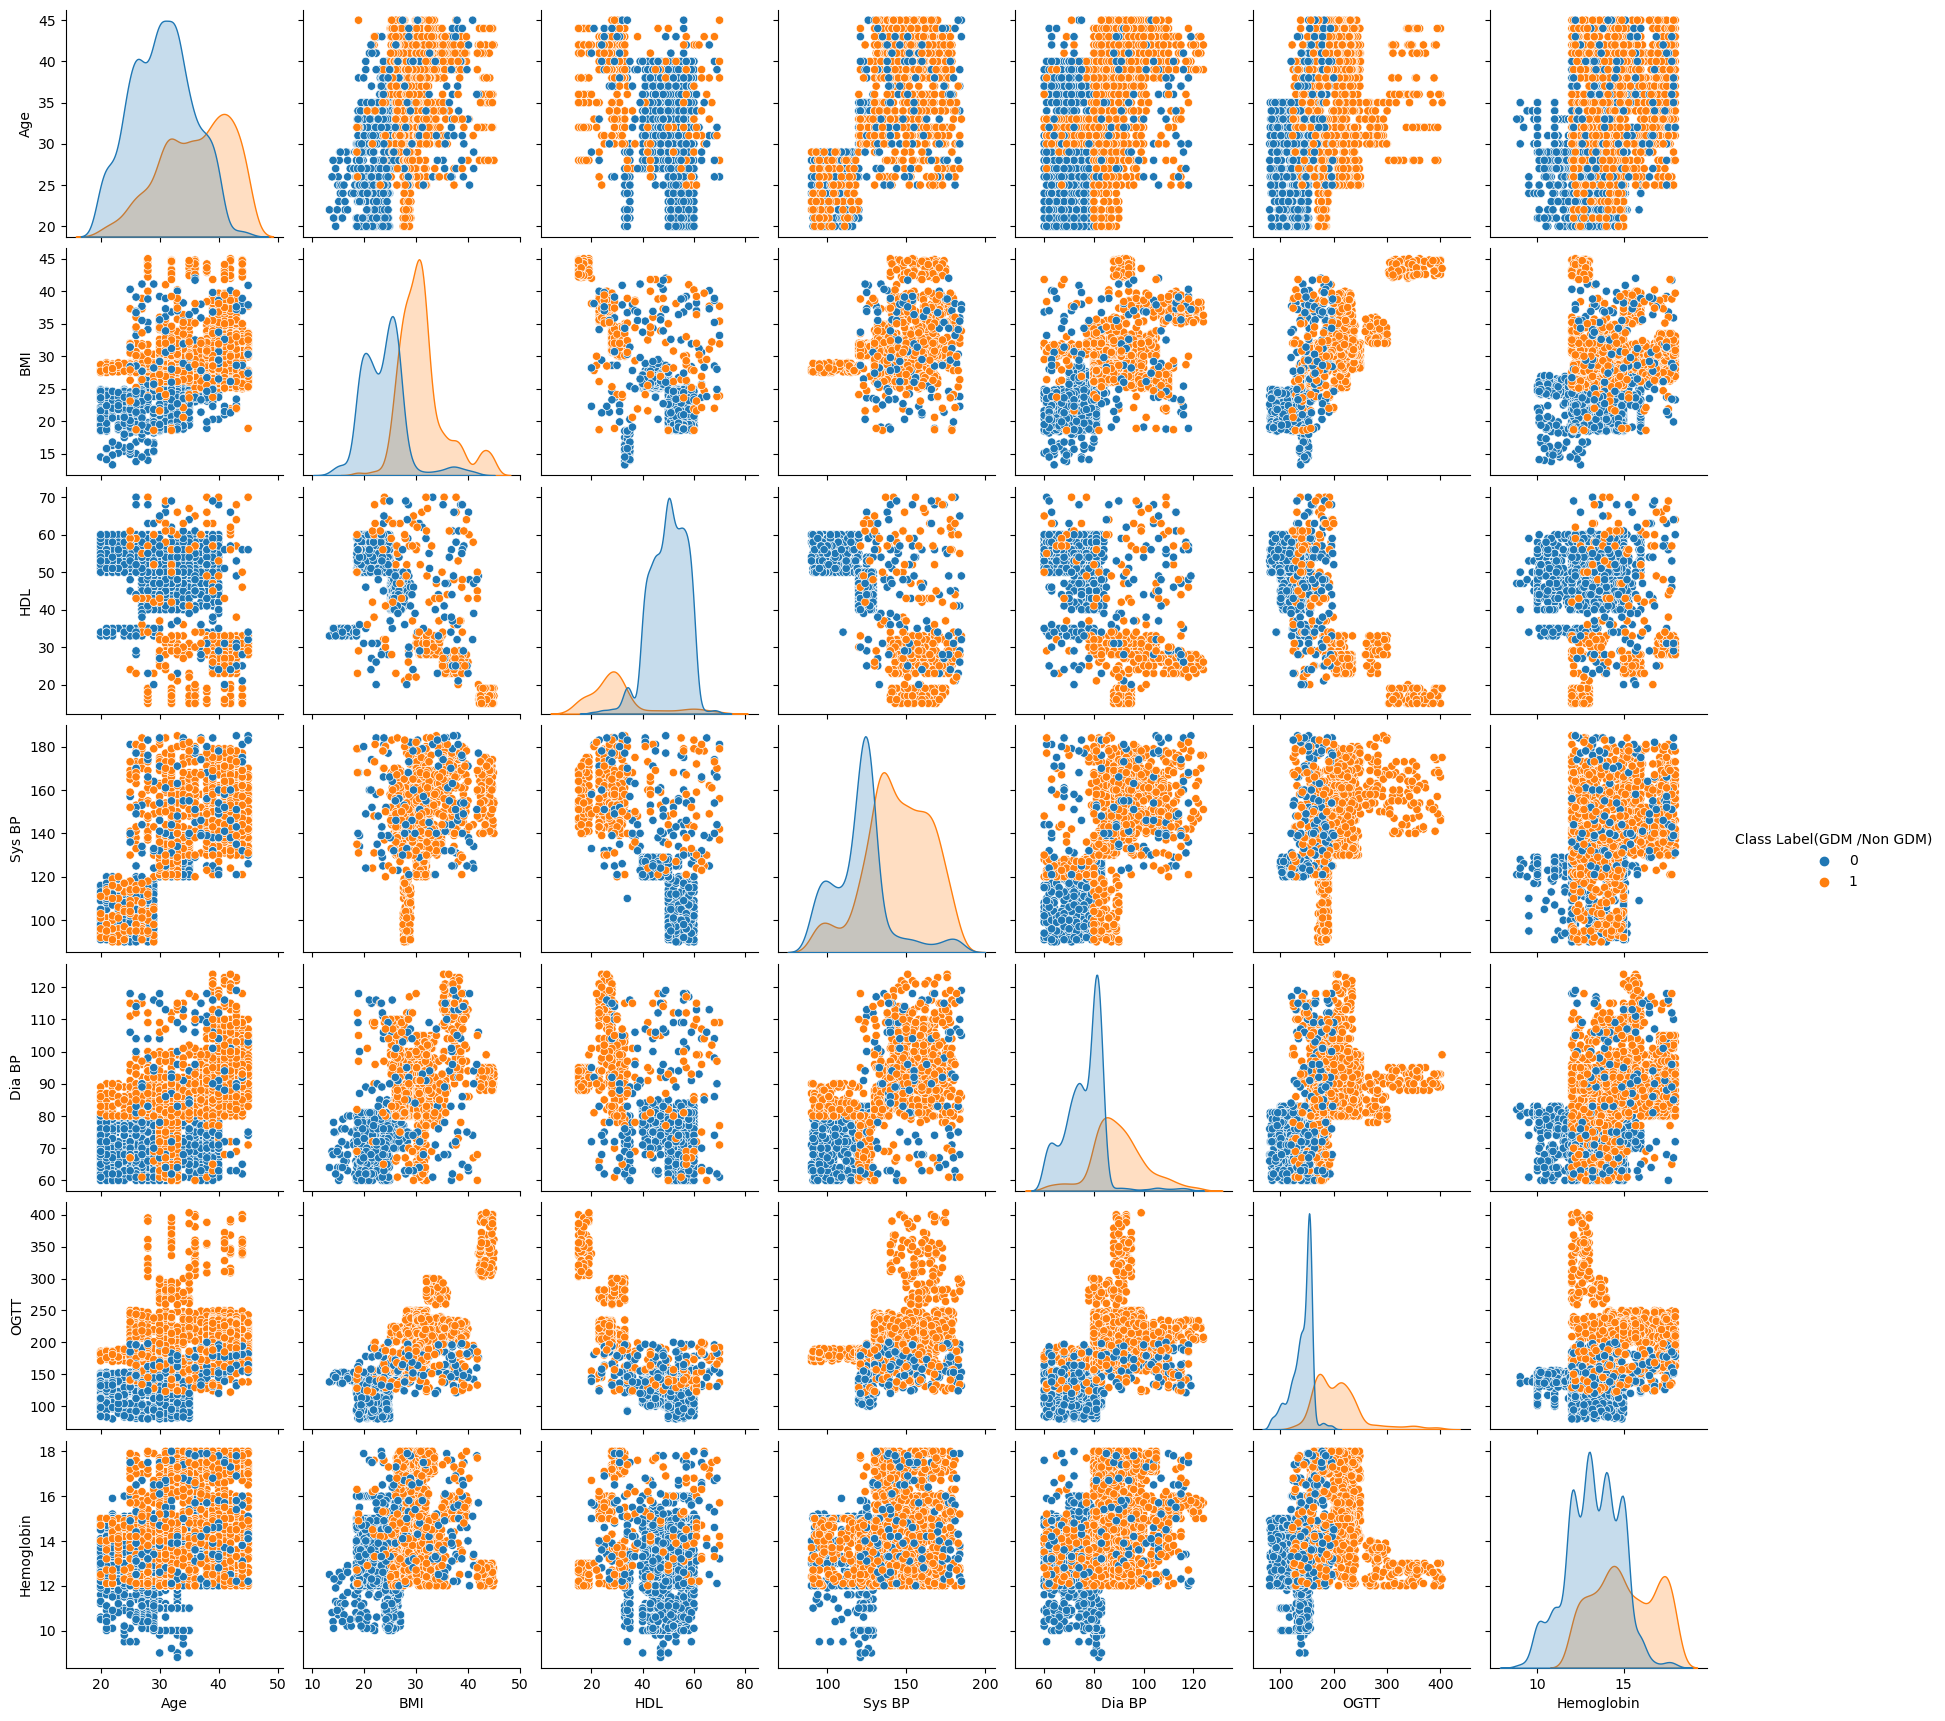

In [127]:
quant = ['Age','BMI','HDL','Sys BP', 'Dia BP', 'OGTT','Hemoglobin']
sns.pairplot(df, hue = GDB, x_vars = quant, y_vars = quant)

In [128]:
df.columns

Index(['Age', 'No of Pregnancy', 'Gestation in previous Pregnancy', 'BMI',
       'HDL', 'Family History', 'unexplained prenetal loss',
       'Large Child or Birth Default', 'PCOS', 'Sys BP', 'Dia BP', 'OGTT',
       'Hemoglobin', 'Sedentary Lifestyle', 'Prediabetes',
       'Class Label(GDM /Non GDM)'],
      dtype='object')

In [129]:
cat = ['No of Pregnancy', 
       'Gestation in previous Pregnancy', 
       'Family History', 
       'unexplained prenetal loss',
       'Large Child or Birth Default',
       'PCOS', 
       'Sedentary Lifestyle', 
       'Prediabetes',
       'Class Label(GDM /Non GDM)']

In [130]:
def compare_cat(col1,col2):
    sns.catplot(data = df, x = col1, y = col2, kind = 'bar')
    sns.catplot(data = df, x = col2, y = col1, kind = 'bar')
    

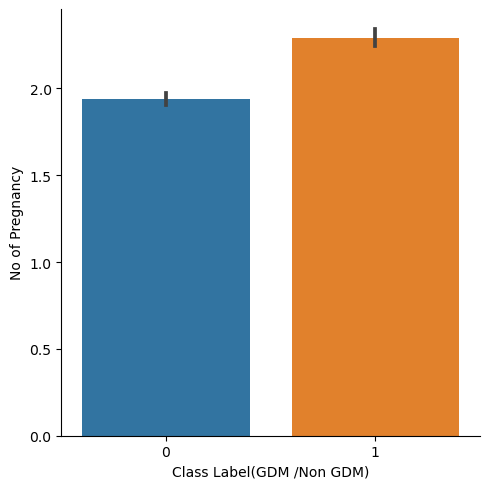

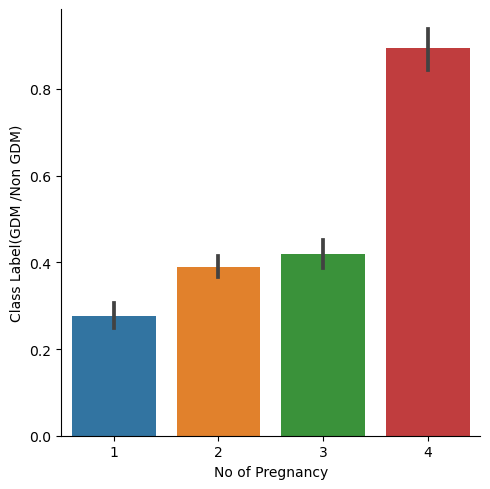

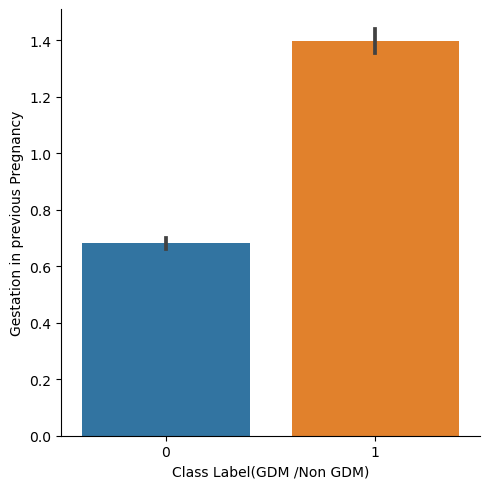

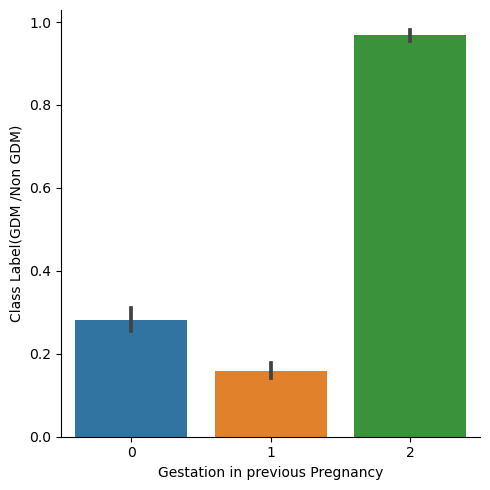

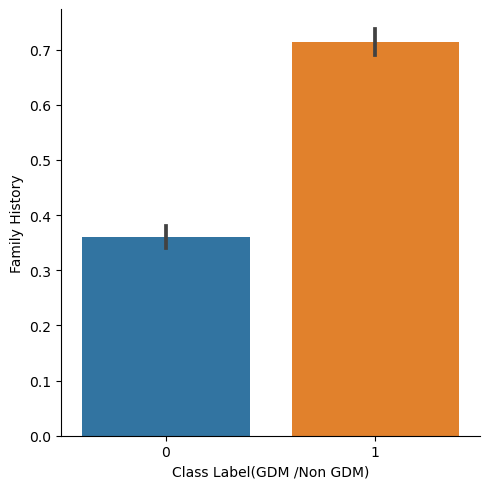

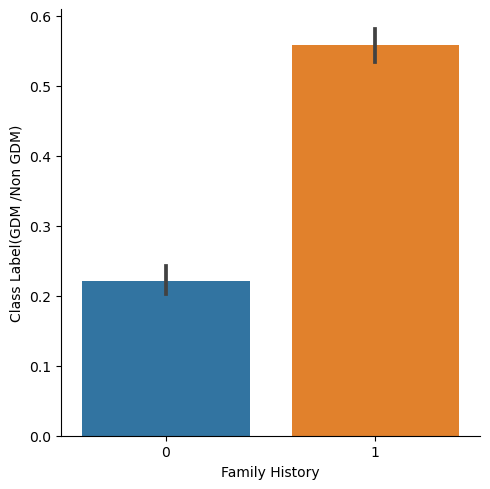

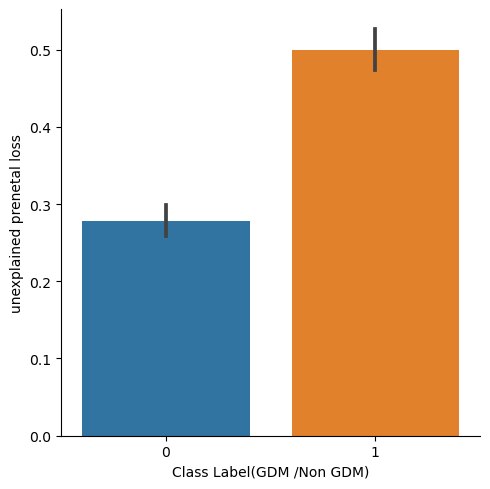

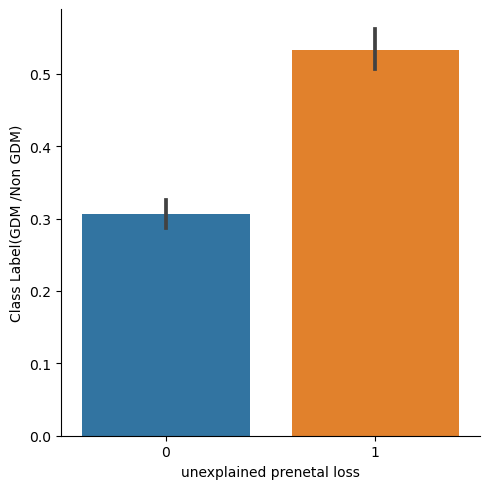

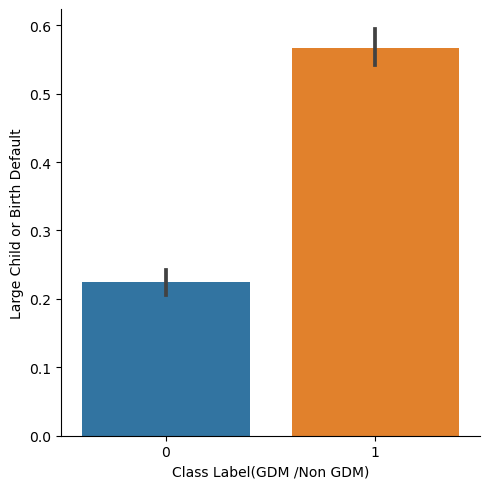

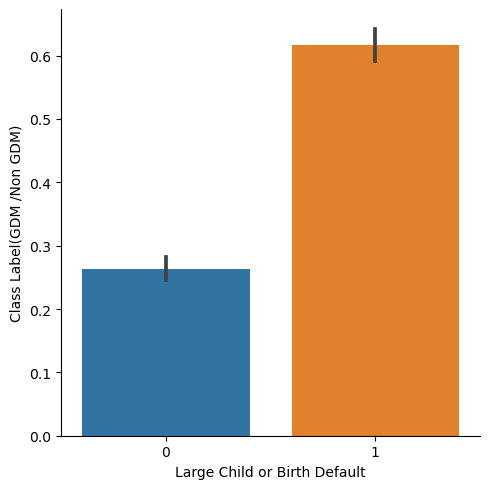

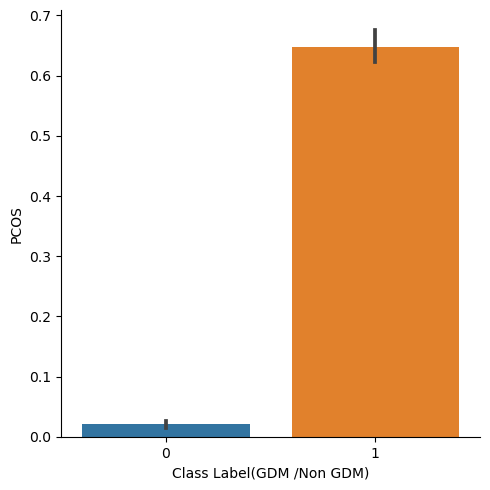

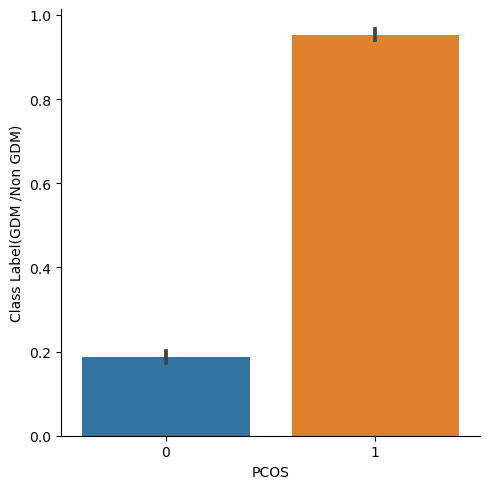

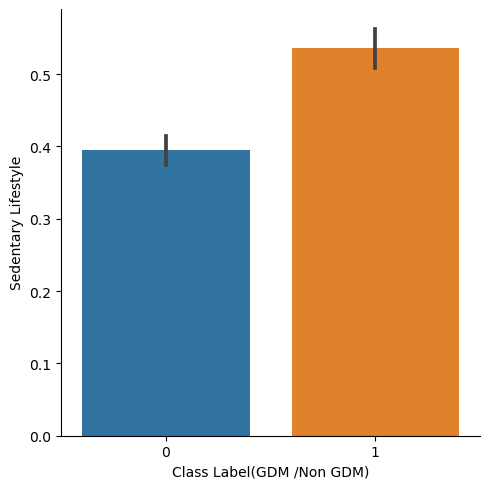

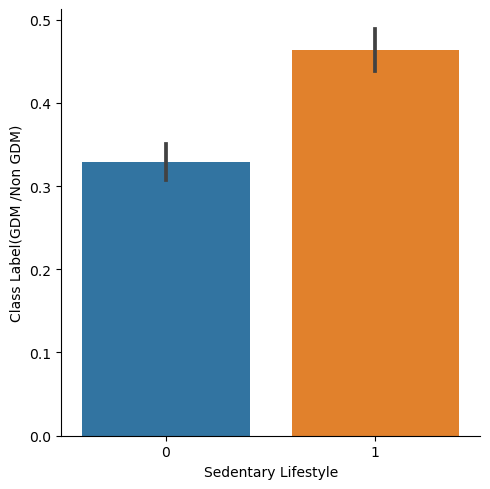

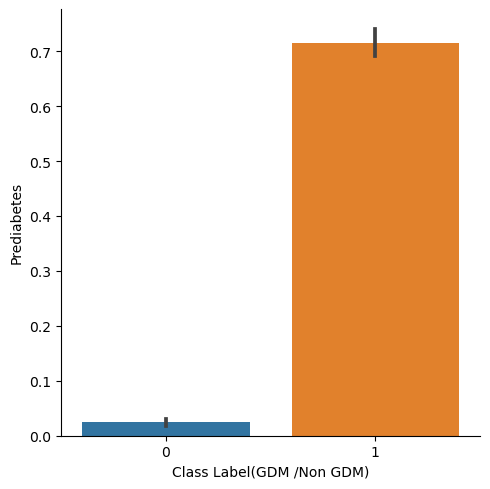

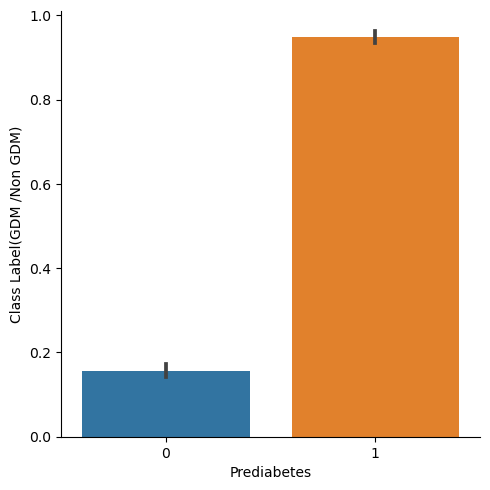

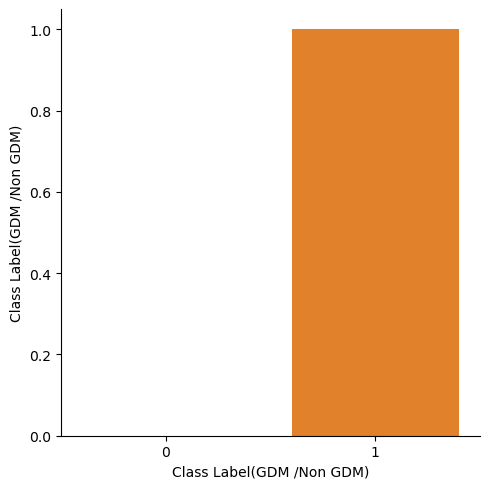

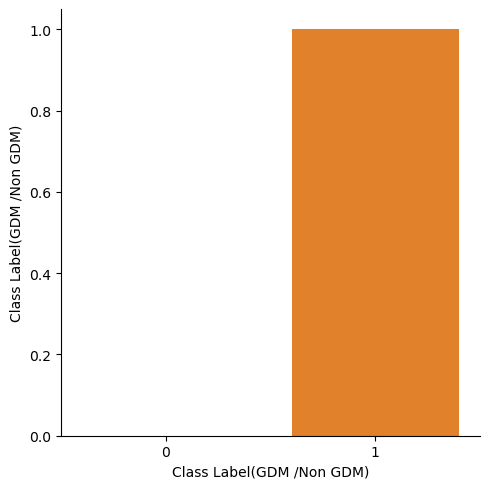

In [131]:
for c in cat:
    compare_cat(GDB, c)

It seems pretty much every variable has some significance; it would be nice to build a model that only used a few easy to measure metrics. How well can we do  with just stuff that would be measured at an annual physical: prediabetes, blood pressure, HDL, age, BMI.

In [132]:
#how many data points can we get if we drop all nan?
len(df.dropna())

526

In [133]:
#if we drop Sys BP first we get much more data.
len(df.drop(columns = 'Sys BP').dropna())

1443

Let's instead try to fill in Nan: we will use mean to fill in HDL and BMI, and we will use
a regression fit to fill in the Sys BP based on the Dia BP.

In [134]:
#HDL and BMI
HDL_mean = np.mean(df['HDL'])
BMI_mean = np.mean(df['BMI'])
df['HDL'].fillna(HDL_mean, inplace = True)
df['BMI'].fillna(BMI_mean, inplace = True)

In [149]:
#Sys BP
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
bp = df[['Sys BP','Dia BP']].dropna()
reg.fit(bp[['Dia BP']], bp[['Sys BP']])
predicted_bp = reg.predict(df[['Dia BP']])
#need to flatten so that fillna can handle it
predicted_bp = [x[0] for x in predicted_bp]
df['Sys BP'] = df['Sys BP'].fillna(pd.Series(predicted_bp))

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3525 entries, 1 to 3525
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              3525 non-null   int64  
 1   No of Pregnancy                  3525 non-null   int64  
 2   Gestation in previous Pregnancy  3525 non-null   int64  
 3   BMI                              3525 non-null   float64
 4   HDL                              3525 non-null   float64
 5   Family History                   3525 non-null   int64  
 6   unexplained prenetal loss        3525 non-null   int64  
 7   Large Child or Birth Default     3525 non-null   int64  
 8   PCOS                             3525 non-null   int64  
 9   Sys BP                           3525 non-null   float64
 10  Dia BP                           3525 non-null   int64  
 11  OGTT                             3012 non-null   float64
 12  Hemoglobin          

In [169]:
df_physical = df[['Dia BP',
                            'Sys BP',
                            'HDL',
                           'BMI', 
                            'Age',
                            'Prediabetes',
                            'Class Label(GDM /Non GDM)']]

In [170]:
#train a Logistic regression model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [171]:
X = df_physical[['Dia BP','HDL','BMI', 'Age']]
y = df_physical[['Class Label(GDM /Non GDM)']]
X_train, X_test, y_train, y_test  = train_test_split(X,y)

In [172]:
model = LogisticRegression()
model.fit(X_train,y_train)

C:\Users\philw\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [173]:
predictions = model.predict(X_test)

In [174]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.97      0.92       542
           1       0.95      0.76      0.84       340

    accuracy                           0.89       882
   macro avg       0.91      0.87      0.88       882
weighted avg       0.90      0.89      0.89       882

[[528  14]
 [ 83 257]]


Let's make some general code to test different models and features.

In [177]:
from sklearn.preprocessing import normalize
def model_test(model,normalized = True):
    """Train the given model on the used
    columns, print classification report and confusion matrix."""
    X = df_physical[['Dia BP','HDL','BMI', 'Age']]
    y = df_physical[['Class Label(GDM /Non GDM)']]
    X_train, X_test, y_train, y_test  = train_test_split(X,y)
    if normalized:
        X_train = normalize(X_train)
        X_test = normalize(X_test)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test,predictions))
    print(confusion_matrix(y_test,predictions))
    

In [181]:
model_test(LogisticRegression(), normalized = False)

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       529
           1       0.93      0.76      0.84       353

    accuracy                           0.88       882
   macro avg       0.89      0.86      0.87       882
weighted avg       0.89      0.88      0.88       882

[[509  20]
 [ 85 268]]


C:\Users\philw\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [176]:
normalize(X_train)

array([[0.7475705 , 0.56067787, 0.26028621, 0.24296041],
       [0.79959888, 0.4442216 , 0.2749642 , 0.29614773],
       [0.80600319, 0.44066442, 0.25317983, 0.30343649],
       ...,
       [0.77870074, 0.47481753, 0.26451222, 0.31337957],
       [0.78947818, 0.5068255 , 0.23586879, 0.25341275],
       [0.78864925, 0.46391132, 0.22638873, 0.33401615]])

In [191]:
from sklearn.neighbors import KNeighborsClassifier
model_test(KNeighborsClassifier(n_neighbors = 6))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       540
           1       0.89      0.80      0.84       342

    accuracy                           0.88       882
   macro avg       0.88      0.87      0.87       882
weighted avg       0.88      0.88      0.88       882

[[505  35]
 [ 69 273]]


C:\Users\philw\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\philw\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [183]:
from sklearn.svm import SVC
model_test(SVC())

C:\Users\philw\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.82      0.84      0.83       551
           1       0.72      0.68      0.70       331

    accuracy                           0.78       882
   macro avg       0.77      0.76      0.77       882
weighted avg       0.78      0.78      0.78       882

[[465  86]
 [105 226]]


In [195]:
#we'll go with a logistic regression model on unnormalized data.

In [196]:
#let's look at the predictions

In [204]:
probs = model.predict_proba(X)[:,1]
df_physical['Probability of Gestational Diabetes'] = probs

C:\Users\philw\AppData\Local\Temp\ipykernel_81156\737398582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_physical['Probability of Gestational Diabetes'] = probs


In [205]:
df_physical

,Dia BP,Sys BP,HDL,BMI,Age,Prediabetes,Class Label(GDM /Non GDM),Probability of Gestational Diabetes
Case Number,,,,,,,,
1,69,102.0,55.0,27.854092,22,0,0,0.045372
2,63,101.0,53.0,27.854092,26,0,0,0.026030
3,79,118.0,50.0,27.854092,29,0,0,0.219104
4,70,99.0,51.0,27.854092,28,0,0,0.072571
5,65,116.0,52.0,27.854092,21,0,0,0.027047
...,...,...,...,...,...,...,...,...
3521,107,150.0,32.0,24.100000,31,1,1,0.782548
3522,85,166.0,43.0,34.500000,26,0,1,0.914885
3523,81,178.0,56.0,23.600000,35,1,1,0.066393


In [197]:
X

,Dia BP,HDL,BMI,Age
Case Number,,,,
1,69,55.0,27.854092,22
2,63,53.0,27.854092,26
3,79,50.0,27.854092,29
4,70,51.0,27.854092,28
5,65,52.0,27.854092,21
...,...,...,...,...
3521,107,32.0,24.100000,31
3522,85,43.0,34.500000,26
3523,81,56.0,23.600000,35
